In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.stats import sem
import scipy.stats as stats

C:\anaconda3\envs\data\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [ ]:
# folder names for each participant
part_names_all = [] 
#start and end times for each participants data stream
sl_start = [25150,61700,72400,31100,36700,54550,84000,78500,98400,92600,103700,65500]
sl_end = [26000,62550,73300,32000,37600,55400,84900,79400,99300,93500,104600,66400]
nSubj = len(part_names_all)
all_df =pd.DataFrame()

dat_path = os.getcwd()+"/data/"
all_hits = np.zeros((nSubj,4))
RTs = np.full((nSubj,4,2,20),np.nan)
first_fix_dur = np.full((nSubj,4,2,20),np.nan)
fix_dur_means = np.full((nSubj,4,2,20),np.nan)
hr_win_sc = 3;

for iSub,idSub in enumerate(part_names_all):
    path = dat_path+idSub
    flist = os.listdir(path)

    for i in range(len(flist)):
        
        if "cue_state" in flist[i]:
            cue_df = pd.read_csv(path+"/"+flist[i])
            cue_df.columns = ["timestamp","channel_0"]
            cue_df = cue_df[(cue_df.timestamp>(sl_start[iSub]-1)) & (cue_df.timestamp<(sl_end[iSub]+1))].reset_index()

            print(flist[i])

        elif "fixations" in flist[i]:
            fix_arr = np.load(path+"/"+flist[i])
            
            fix_arr = fix_arr[(fix_arr>(sl_start[iSub]-1)) & (fix_arr<(sl_end[iSub]+1))]

            print(flist[i])
        elif "gaze" in flist[i]:
            gaze_arr = np.load(path+"/"+flist[i])
            
            gaze_arr = gaze_arr[(gaze_arr>(sl_start[iSub]-1)) & (gaze_arr<(sl_end[iSub]+1))]

            print(flist[i])
        elif "rob_state" in flist[i]:
            robst_df = pd.read_csv(path+"/"+flist[i])
            robst_df.columns = ["timestamp","channel_0"]
            robst_df = robst_df[(robst_df.timestamp>(sl_start[iSub]-1)) & (robst_df.timestamp<(sl_end[iSub]+1))].reset_index()
            robst_df.reset_index()
        
    
            print(flist[i])
        elif "user_input" in flist[i]:
            resp_df = pd.read_csv(path+"/"+flist[i])
            resp_df.columns = ["timestamp","channel_0"]
            resp_df = resp_df[(resp_df.timestamp>(sl_start[iSub]-1)) & (resp_df.timestamp<(sl_end[iSub]+1))].reset_index()
            resp_df.reset_index()
    

            print(flist[i]) 
    cue_1_idx = find_peaks(cue_df.channel_0,[1,1],distance=100)
    cue_2_idx = find_peaks(cue_df.channel_0,height=[2,2],distance=100)
    cue_3_idx = find_peaks(cue_df.channel_0,height=[3,3],distance=100)
    cue_4_idx = find_peaks(cue_df.channel_0,[4,4],distance=100)
    all_cue_idx = np.sort(np.concatenate([cue_1_idx[0],cue_2_idx[0],cue_3_idx[0],cue_4_idx[0]]))
    all_cue_ts =  np.array(cue_df.timestamp[all_cue_idx])
    resp_idx = find_peaks(resp_df.channel_0,[1,1],distance=100)
    hits = [0,0,0,0]
    for iCue in range(len(cue_1_idx[0])):
        #NO CUE
        cue_ts = cue_df.timestamp[cue_1_idx[0][iCue]]
        rob_win = robst_df[(robst_df.timestamp>(cue_ts-1))& (robst_df.timestamp<(cue_ts+1))].reset_index()
        rob_state = max(rob_win.channel_0)
        rob_ts = rob_win.timestamp[rob_win.channel_0!=0].values
        rob_ts = rob_ts[0]
        resp_win = resp_df[(resp_df.timestamp>(cue_ts))& (resp_df.timestamp<(cue_ts+5))].reset_index()
        resp_idx = np.where(resp_win.channel_0==1)[0]
        fix_win = fix_arr[(fix_arr>(cue_ts-10))& (fix_arr<(cue_ts+5))]
        print(cue_ts)
        gaze_win = gaze_arr[(gaze_arr>(cue_ts-1))& (gaze_arr<(cue_ts+5))]

        rt=0
        if len(resp_idx)>0:
            if rob_state ==1:
                resp_ts = resp_win.timestamp[resp_idx[0]]
                hits[0] = hits[0]+1
                rt = resp_ts-rob_ts
                RTs[iSub,0,rob_state-1,iCue] = rt
                print("No CUE: ",rt)
                tmp_dct = {'Correct':True,'RT':rt,'ID':iSub,'Cue':0}
                all_df = pd.concat([all_df,pd.DataFrame(tmp_dct,index=[0])],ignore_index=True)
        
        
        #AUD CUE
        cue_ts = cue_df.timestamp[cue_2_idx[0][iCue]]
        rob_win = robst_df[(robst_df.timestamp>(cue_ts-1))& (robst_df.timestamp<(cue_ts+1))].reset_index()
        rob_state = max(rob_win.channel_0)
        rob_ts = rob_win.timestamp[rob_win.channel_0!=0].values
        rob_ts = rob_ts[0]
        resp_win = resp_df[(resp_df.timestamp>(cue_ts))& (resp_df.timestamp<(cue_ts+5))].reset_index()
        resp_idx = np.where(resp_win.channel_0==1)[0]
        rt=0
        if len(resp_idx)>0:
            if rob_state ==1:
                resp_ts = resp_win.timestamp[resp_idx[0]]
                rt = resp_ts-rob_ts
                hits[1] = hits[1]+1
                RTs[iSub,1,rob_state-1,iCue] = rt
                print("AUD CUE: ",rt)
                tmp_dct = {'Correct':True,'RT':rt,'ID':iSub,'Cue':1}
                all_df = pd.concat([all_df,pd.DataFrame(tmp_dct,index=[0])],ignore_index=True)        
        
        #HAP CUE
        cue_ts = cue_df.timestamp[cue_3_idx[0][iCue]]
        rob_win = robst_df[(robst_df.timestamp>(cue_ts-1))& (robst_df.timestamp<(cue_ts+1))].reset_index()
        rob_state = max(rob_win.channel_0)
        rob_ts = rob_win.timestamp[rob_win.channel_0!=0].values
        rob_ts = rob_ts[0]
        resp_win = resp_df[(resp_df.timestamp>(cue_ts))& (resp_df.timestamp<(cue_ts+5))].reset_index()
        resp_idx = np.where(resp_win.channel_0==1)[0]

        
        rt=0
        if len(resp_idx)>0:
            if rob_state ==1:

                resp_ts = resp_win.timestamp[resp_idx[0]]
                rt = resp_ts-rob_ts
                hits[2] = hits[2]+1
                RTs[iSub,2,rob_state-1,iCue] = rt
                tmp_dct = {'Correct':True,'RT':rt,'ID':iSub,'Cue':2}
                all_df = pd.concat([all_df,pd.DataFrame(tmp_dct,index=[0])],ignore_index=True)     
                print("HAP CUE: ",rt)
       
        #MS CUE
        cue_ts = cue_df.timestamp[cue_4_idx[0][iCue]]
        rob_win = robst_df[(robst_df.timestamp>(cue_ts-1))& (robst_df.timestamp<(cue_ts+1))].reset_index()
        rob_state = max(rob_win.channel_0)
        rob_ts = rob_win.timestamp[rob_win.channel_0!=0].values
        rob_ts = rob_ts[0]

        resp_win = resp_df[(resp_df.timestamp>cue_ts)& (resp_df.timestamp<(cue_ts+5))].reset_index()
        resp_idx = np.where(resp_win.channel_0==1)[0]
        #plt.plot(rob_win.timestamp,rob_win.channel_0)
        #plt.plot(resp_win.timestamp,resp_win.channel_0)
        #plt.show()
        rt=0

        if len(resp_idx)>0:
            if rob_state ==1:
                resp_ts = resp_win.timestamp[resp_idx[0]]
                rt = resp_ts-rob_ts
                hits[3] = hits[3]+1
                RTs[iSub,3,rob_state-1,iCue] = rt
                print("MS CUE: ",rt)
                tmp_dct = {'Correct':True,'RT':rt,'ID':iSub,'Cue':3}
                all_df = pd.concat([all_df,pd.DataFrame(tmp_dct,index=[0])],ignore_index=True)    
    print(np.nanmean(RTs[iSub,:,0,:],axis=1))
        
    all_hits[iSub,:] = hits

In [ ]:
# folder names for each participant
part_names_all = [] 
sl_start = [146250,166100,162750,80850,76450,171800,149350,231250]
sl_end = [147100,167000,163600,81800,77500,172700,150300,232100]
nSubj = len(part_names_all)
part_names = ['SZ']
dat_path = os.getcwd()+"/data_old/"
all_hits_old = np.zeros((nSubj,4))
RTs_old = np.full((nSubj,4,2,20),np.nan)
for iSub,idSub in enumerate(part_names_all):
    path = dat_path+idSub
    flist = os.listdir(path)

    for i in range(len(flist)):
        
        if "cue_state" in flist[i]:
            cue_df = pd.read_csv(path+"/"+flist[i])
            cue_df.columns = ["timestamp","channel_0"]
            cue_df = cue_df[(cue_df.timestamp>(sl_start[iSub]-1)) & (cue_df.timestamp<(sl_end[iSub]+1))].reset_index()
            #plt.figure(figsize=(12,12))
            #plt.plot(cue_df.timestamp,cue_df.channel_0)
            #plt.show()
            print(flist[i])
        elif "robot_state" in flist[i]:
            robst_df = pd.read_csv(path+"/"+flist[i])
            robst_df.columns = ["timestamp","channel_0"]
            robst_df = robst_df[(robst_df.timestamp>(sl_start[iSub]-1)) & (robst_df.timestamp<(sl_end[iSub]+1))].reset_index()
            #robst_df.reset_index()
        
    
    
    #plt.figure(figsize=(12,12))
            #plt.plot(robst_df.timestamp,robst_df.channel_0)
            #plt.show()
            print(flist[i])
        elif "buttonserver" in flist[i]:
            resp_df = pd.read_csv(path+"/"+flist[i])
            resp_df.columns = ["timestamp","channel_0"]
            resp_df = resp_df[(resp_df.timestamp>(sl_start[iSub]-1)) & (resp_df.timestamp<(sl_end[iSub]+1))].reset_index()
            #resp_df.reset_index()

            #plt.figure(figsize=(12,12))
            #plt.plot(resp_df.timestamp,resp_df.channel_0)
            #plt.show()
            print(flist[i]) 
    cue_1_idx = find_peaks(cue_df.channel_0,[1,1],distance=100)
    cue_2_idx = find_peaks(cue_df.channel_0,height=[2,2],distance=100)
    cue_3_idx = find_peaks(cue_df.channel_0,height=[3,3],distance=100)
    cue_4_idx = find_peaks(cue_df.channel_0,[4,4],distance=100)
    all_cue_idx = np.sort(np.concatenate([cue_1_idx[0],cue_2_idx[0],cue_3_idx[0],cue_4_idx[0]]))
    all_cue_ts =  np.array(cue_df.timestamp[all_cue_idx])
    resp_idx = find_peaks(resp_df.channel_0,[1,1],distance=100)
    hits = [0,0,0,0]
    for iCue in range(len(cue_1_idx[0])):
        #NO CUE
        cue_ts = cue_df.timestamp[cue_1_idx[0][iCue]]
        rob_win = robst_df[(robst_df.timestamp>(cue_ts-1))& (robst_df.timestamp<(cue_ts+1))].reset_index()
        rob_state = max(rob_win.channel_0)
        rob_ts = rob_win.timestamp[rob_win.channel_0!=0].values
        rob_ts = rob_ts[0]
        resp_win = resp_df[(resp_df.timestamp>(cue_ts))& (resp_df.timestamp<(cue_ts+5))].reset_index()
        resp_idx = np.where(resp_win.channel_0==1)[0]
        rt=0
        if len(resp_idx)>0:
            if rob_state ==1:
                resp_ts = resp_win.timestamp[resp_idx[0]]
                hits[0] = hits[0]+1
                rt = resp_ts-rob_ts
                RTs_old[iSub,0,rob_state-1,iCue] = rt
                tmp_dct = {'Correct':True,'RT':rt,'ID':iSub+11,'Cue':3}
                all_df = pd.concat([all_df,pd.DataFrame(tmp_dct,index=[0])],ignore_index=True)    
                print("No CUE: ",rt)
        
        
        #AUD CUE
        cue_ts = cue_df.timestamp[cue_2_idx[0][iCue]]
        rob_win = robst_df[(robst_df.timestamp>(cue_ts-1))& (robst_df.timestamp<(cue_ts+1))].reset_index()
        rob_state = max(rob_win.channel_0)
        rob_ts = rob_win.timestamp[rob_win.channel_0!=0].values
        rob_ts = rob_ts[0]
        resp_win = resp_df[(resp_df.timestamp>(cue_ts))& (resp_df.timestamp<(cue_ts+5))].reset_index()
        resp_idx = np.where(resp_win.channel_0==1)[0]
        rt=0
        if len(resp_idx)>0:
            if rob_state ==1:
                resp_ts = resp_win.timestamp[resp_idx[0]]
                rt = resp_ts-rob_ts
                hits[1] = hits[1]+1
                RTs_old[iSub,1,rob_state-1,iCue] = rt
                tmp_dct = {'Correct':True,'RT':rt,'ID':iSub+11,'Cue':1}
                all_df = pd.concat([all_df,pd.DataFrame(tmp_dct,index=[0])],ignore_index=True)   
                print("AUD CUE: ",rt)
        
        
        #HAP CUE
        cue_ts = cue_df.timestamp[cue_3_idx[0][iCue]]
        rob_win = robst_df[(robst_df.timestamp>(cue_ts-1))& (robst_df.timestamp<(cue_ts+1))].reset_index()
        rob_state = max(rob_win.channel_0)
        rob_ts = rob_win.timestamp[rob_win.channel_0!=0].values
        rob_ts = rob_ts[0]
        resp_win = resp_df[(resp_df.timestamp>(cue_ts))& (resp_df.timestamp<(cue_ts+5))].reset_index()
        resp_idx = np.where(resp_win.channel_0==1)[0]

        
        rt=0
        if len(resp_idx)>0:
            if rob_state ==1:

                resp_ts = resp_win.timestamp[resp_idx[0]]
                rt = resp_ts-rob_ts
                hits[2] = hits[2]+1
                RTs_old[iSub,2,rob_state-1,iCue] = rt
                tmp_dct = {'Correct':True,'RT':rt,'ID':iSub+11,'Cue':2}
                all_df = pd.concat([all_df,pd.DataFrame(tmp_dct,index=[0])],ignore_index=True)   
                print("HAP CUE: ",rt)
       
        #MS CUE
        cue_ts = cue_df.timestamp[cue_4_idx[0][iCue]]
        rob_win = robst_df[(robst_df.timestamp>(cue_ts-1))& (robst_df.timestamp<(cue_ts+1))].reset_index()
        rob_state = max(rob_win.channel_0)
        rob_ts = rob_win.timestamp[rob_win.channel_0!=0].values
        rob_ts = rob_ts[0]

        resp_win = resp_df[(resp_df.timestamp>cue_ts)& (resp_df.timestamp<(cue_ts+5))].reset_index()
        resp_idx = np.where(resp_win.channel_0==1)[0]
        #plt.plot(rob_win.timestamp,rob_win.channel_0)
        #plt.plot(resp_win.timestamp,resp_win.channel_0)
        #plt.show()
        rt=0

        if len(resp_idx)>0:
            if rob_state ==1:
                resp_ts = resp_win.timestamp[resp_idx[0]]
                rt = resp_ts-rob_ts
                hits[3] = hits[3]+1
                RTs_old[iSub,3,rob_state-1,iCue] = rt
                print("MS CUE: ",rt)
                tmp_dct = {'Correct':True,'RT':rt,'ID':iSub+11,'Cue':0}
                all_df = pd.concat([all_df,pd.DataFrame(tmp_dct,index=[0])],ignore_index=True)   
    print(np.nanmean(RTs_old[iSub,:,0,:],axis=1))
        
    all_hits_old[iSub,:] = hits

In [10]:
all_df.to_csv('PipPopRobotsDF.csv')

In [11]:
all_df.groupby(["Cue"]).mean(["RT"]).reset_index()

,Cue,Correct,RT,ID
0,0,1.0,1.413363,8.956044
1,1,1.0,1.131231,8.957447
2,2,1.0,1.096263,8.864865
3,3,1.0,1.106677,8.876344


In [12]:
all_hits=np.vstack([all_hits,all_hits_old])
np.mean(all_hits/10,axis=0)

array([0.96315789, 0.98947368, 0.97368421, 0.97368421])

In [14]:
mean_RTs_old = np.nanmean(RTs_old,axis=3)
mean_RTs_old = mean_RTs_old[:,:,0]

mean_RTs_old[:,0],mean_RTs_old[:,3] = mean_RTs_old[:,3], mean_RTs_old[:,0].copy()



C:\Users\Bora Celebi\AppData\Local\Temp\ipykernel_22708\3373592393.py:1: RuntimeWarning: Mean of empty slice
  mean_RTs_old = np.nanmean(RTs_old,axis=3)


<ErrorbarContainer object of 3 artists>

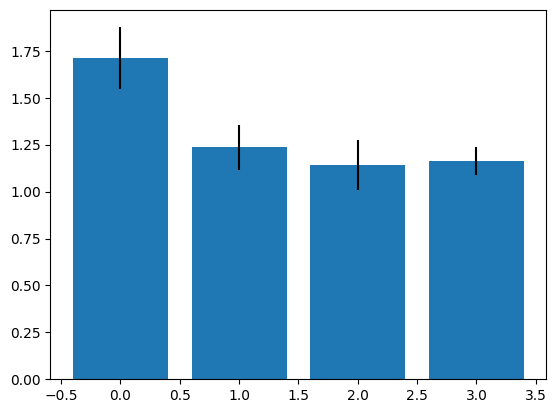

In [16]:
from scipy.stats import sem
means = [np.nanmean(mean_RTs_old[:,0]),np.nanmean(mean_RTs_old[:,1]),np.nanmean(mean_RTs_old[:,2]),
         np.nanmean(mean_RTs_old[:,3])]
sems = [sem(mean_RTs_old,axis=0)]
plt.bar([0,1,2,3],means)
plt.errorbar([0,1,2,3],means,yerr=sems,fmt='None',color='k')

In [17]:
RTs_old[:,0,:,:],RTs_old[:,3,:,:] = RTs_old[:,3,:,:], RTs_old[:,0,:,:].copy()


In [18]:
rt_mat= np.concatenate([RTs_old[:,:,0,:],RTs[:,:,0,:]],axis=0)


1.1041274264772474

In [19]:
np.savez("RT_array.npz",rt_mat=rt_mat)

In [20]:
col_pal = ['#C3C8CD','#A8ADB4','#868F98','#606A74','#414B56','#212930']

[1.4289737854309783, 1.135695341882326, 1.0941482142268302, 1.1041274264772474]
[array([0.09259964, 0.05526037, 0.05732963, 0.03774311])]


Text(0, 0.5, 'Reaction Time [s]')

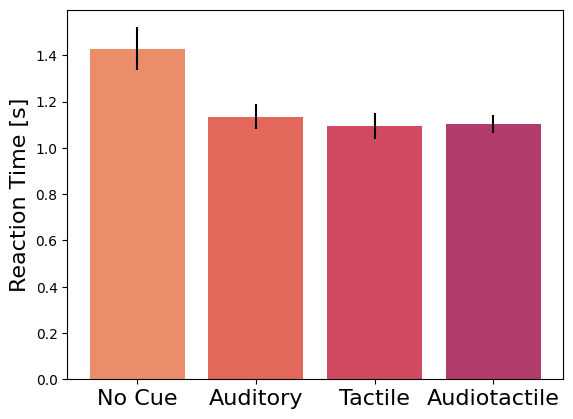

In [26]:
import seaborn as sns
all_mean_RTs= np.concatenate([mean_RTs_old,mean_RTs])
means = [np.nanmean(all_mean_RTs[:,0]),np.nanmean(all_mean_RTs[:,1]),np.nanmean(all_mean_RTs[:,2]),
         np.nanmean(all_mean_RTs[:,3])]
print(means)
print(sems)
sems = [sem(all_mean_RTs,axis=0)]
plt.bar([0,1,2,3],means,color = sns.color_palette("flare"))
plt.errorbar([0,1,2,3],means,yerr=sems,fmt='None',color='k')
plt.xticks([0,1,2,3],labels=['No Cue','Auditory','Tactile','Audiotactile'],fontsize=16)
plt.ylabel('Reaction Time [s]',fontsize=16)

In [60]:
ids = np.arange(len(all_mean_RTs))
ids = ids+1
rt_df = pd.DataFrame(all_mean_RTs,columns=['No Cue','Auditory Cue','Tactile Cue','MSCue'])
rt_df['ID'] = ids
rt_df=pd.melt(rt_df,id_vars=['ID'])
rt_df.columns=['ID','Cueing','RT']
rt_df

,ID,Cueing,RT
0,1,No Cue,1.404923
1,2,No Cue,2.657304
2,3,No Cue,1.873966
3,4,No Cue,1.583252
4,5,No Cue,1.263037
...,...,...,...
71,15,MSCue,1.000798
72,16,MSCue,0.997332
73,17,MSCue,1.004833
74,18,MSCue,1.001807


In [82]:
 rt_df.Cueing

,ID,Cueing,RT
0,1,No Cue,1.404923
1,2,No Cue,2.657304
2,3,No Cue,1.873966
3,4,No Cue,1.583252
4,5,No Cue,1.263037
...,...,...,...
71,15,MSCue,1.000798
72,16,MSCue,0.997332
73,17,MSCue,1.004833
74,18,MSCue,1.001807


In [81]:
chi = pg.sphericity(dv='RT', within='Cueing',
                  subject='ID', data=rt_df,method="mauchly")
chi

SpherResults(spher=True, W=0.6432366391334084, chi2=7.378556792933068, dof=5, pval=0.19465381047709956)

In [76]:
import pingouin

aov = pg.rm_anova(dv='RT', within='Cueing',
                  subject='ID', data=rt_df, detailed=True, effsize="np2")
aov

,Source,SS,DF,MS,F,p-unc,np2,eps
0,Cueing,1.455722,3,0.485241,10.828546,0.000011,0.375619,0.756358
1,Error,2.419808,54,0.044811,NaN,NaN,NaN,NaN


In [64]:
post_hocs = pg.pairwise_tests(dv='RT', within='Cueing', subject='ID', data=rt_df,padjust='bonf',effsize='cohen',return_desc=True)
post_hocs

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,Cueing,Auditory Cue,MSCue,1.135695,0.240874,1.104127,0.164518,True,True,0.550143,18.0,two-sided,0.588983,1.000000,bonf,0.272,0.153049
1,Cueing,Auditory Cue,No Cue,1.135695,0.240874,1.428974,0.403632,True,True,-3.823111,18.0,two-sided,0.001246,0.007473,bonf,30.567,-0.882385
2,Cueing,Auditory Cue,Tactile Cue,1.135695,0.240874,1.094148,0.249894,True,True,0.794180,18.0,two-sided,0.437437,1.000000,bonf,0.314,0.169286
3,Cueing,MSCue,No Cue,1.104127,0.164518,1.428974,0.403632,True,True,-3.621439,18.0,two-sided,0.001952,0.011711,bonf,20.748,-1.053981
4,Cueing,MSCue,Tactile Cue,1.104127,0.164518,1.094148,0.249894,True,True,0.165125,18.0,two-sided,0.870686,1.000000,bonf,0.24,0.047170
5,Cueing,No Cue,Tactile Cue,1.428974,0.403632,1.094148,0.249894,True,True,4.889591,18.0,two-sided,0.000118,0.000708,bonf,241.851,0.997446
